# 03. Моделирование для VK EdTech ML Challenge

В этом ноутбуке:
* заново строим признаки кампаний `features_df` по рабочему коду (1008 строк);
* обучаем RandomForest-классификатор по 3 классам;
* обучаем stacking-регрессии по каждому таргету.

ЭТАП 1. Импорт библиотек, глобальные переменные и контроль reproducibility

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns

# ML / CV
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.isotonic import IsotonicRegression

# Пути к данным для Colab (адаптируйте под свою среду)
FOLDER = '/content/drive/MyDrive/VK_Project_v2'

# Глобальные параметры для воспроизводимости
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Отключаем сторонние ворнинги для чистоты вывода
import warnings
warnings.filterwarnings("ignore")

print("Импорт и настройка окружения завершены.")

Импорт и настройка окружения завершены.


# ЭТАП 2. Загрузка данных и предварительный просмотр

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Ожидаются .tsv-файлы для users, history, validate, validate_answers

users = pd.read_csv(os.path.join(FOLDER, 'users.tsv'), sep='\t')
history = pd.read_csv(os.path.join(FOLDER, 'history.tsv'), sep='\t')
validate = pd.read_csv(os.path.join(FOLDER, 'validate.tsv'), sep='\t')
validate_answers = pd.read_csv(os.path.join(FOLDER, 'validate_answers.tsv'), sep='\t')

print(f'users: shape {users.shape}, колонки: {users.columns.tolist()}')
print(f'history: shape {history.shape}, колонки: {history.columns.tolist()}')
print(f'validate: shape {validate.shape}, колонки: {validate.columns.tolist()}')
print(f'validate_answers: shape {validate_answers.shape}, колонки: {validate_answers.columns.tolist()}')

# Просто быстрый просмотр первых строк каждого файла
print("\n== Примеры данных (users) ==")
display(users.head())
print("\n== Примеры данных (history) ==")
display(history.head())
print("\n== Примеры данных (validate) ==")
display(validate.head())
print("\n== Примеры данных (validate_answers) ==")
display(validate_answers.head())

users: shape (27769, 4), колонки: ['user_id', 'sex', 'age', 'city_id']
history: shape (1147857, 4), колонки: ['hour', 'cpm', 'publisher', 'user_id']
validate: shape (1008, 6), колонки: ['cpm', 'hour_start', 'hour_end', 'publishers', 'audience_size', 'user_ids']
validate_answers: shape (1008, 3), колонки: ['at_least_one', 'at_least_two', 'at_least_three']

== Примеры данных (users) ==


,user_id,sex,age,city_id
0,0,2,19,0
1,1,1,0,1
2,2,2,24,2
3,3,1,20,3
4,4,2,29,4



== Примеры данных (history) ==


,hour,cpm,publisher,user_id
0,10,30.00,1,15661
1,8,41.26,1,8444
2,7,360.00,1,15821
3,18,370.00,1,21530
4,8,195.00,2,22148



== Примеры данных (validate) ==


,cpm,hour_start,hour_end,publishers,audience_size,user_ids
0,220.0,1058,1153,"7,17",1906,"12,44,46,50,58,71,93,122,134,143,176,184,187,1..."
1,312.0,1295,1301,"3,18",1380,"29,81,98,102,165,167,195,205,218,231,242,263,3..."
2,70.0,1229,1249,"1,2,3,9,15,21",888,"12,23,25,29,45,85,92,124,156,190,272,334,456,5..."
3,240.0,1295,1377,"1,14",440,"44,122,187,209,242,255,312,345,382,465,513,524..."
4,262.0,752,990,"1,3,7,8",1476,"15,24,30,43,50,53,96,105,159,168,181,190,196,2..."



== Примеры данных (validate_answers) ==


,at_least_one,at_least_two,at_least_three
0,0.0430,0.0152,0.0073
1,0.0130,0.0000,0.0000
2,0.0878,0.0135,0.0000
3,0.2295,0.1295,0.0727
4,0.3963,0.2785,0.2270


# ЭТАП 3. Первичный анализ данных и визуализация (EDA)

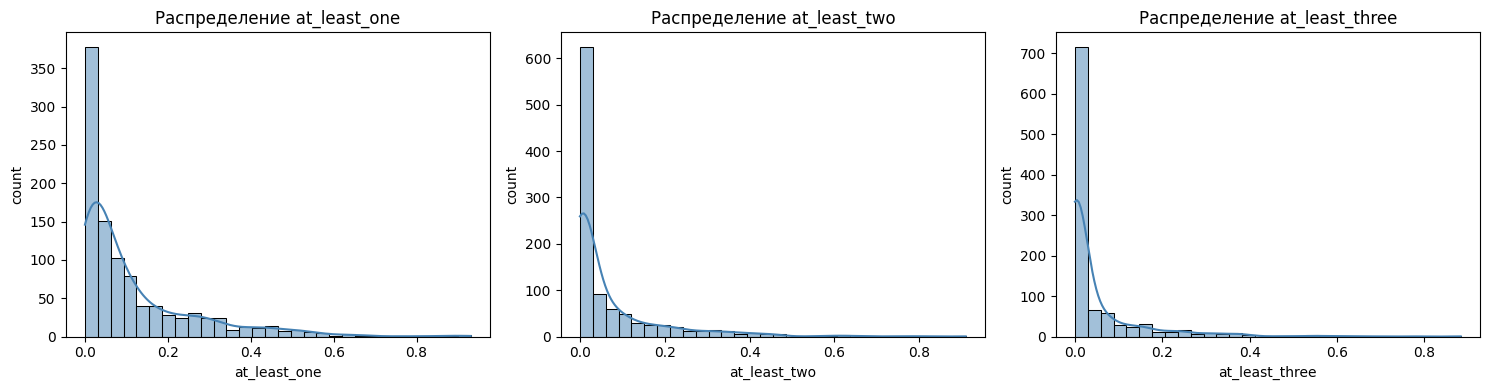

Статистика по целевым переменным:


,at_least_one,at_least_two,at_least_three
count,1008.000000,1008.000000,1008.000000
mean,0.115441,0.065805,0.047170
std,0.146146,0.117812,0.099029
min,0.000000,0.000000,0.000000
25%,0.016650,0.000000,0.000000
50%,0.055250,0.009800,0.001400
75%,0.158700,0.078125,0.048950
max,0.930700,0.909700,0.883400


Пропуски в answers:
at_least_one      0
at_least_two      0
at_least_three    0
dtype: int64

Демография пользователей (users):


,user_id,sex,age,city_id
count,27769.000000,27769.000000,27769.000000,27769.000000
mean,13884.000000,1.475134,28.894847,240.141165
std,8016.364149,0.501549,18.510084,466.122195
min,0.000000,0.000000,0.000000,0.000000
25%,6942.000000,1.000000,18.000000,0.000000
50%,13884.000000,1.000000,27.000000,25.000000
75%,20826.000000,2.000000,36.000000,231.000000
max,27768.000000,2.000000,118.000000,2456.000000



История показов — статистика по CPM:
count    1.147857e+06
mean     1.864043e+02
std      4.557257e+02
min      3.000000e+01
25%      5.500000e+01
50%      1.100000e+02
75%      2.100000e+02
max      2.090540e+05
Name: cpm, dtype: float64
Пропуски в history: 0

Общее число записей в history: 1147857
Число уникальных кампаний в validate: 1008
Пример пользовательских id первой кампании validate: 12,44,46,50,58,71,93,122,134,143,176,184,187,194,209,238,242,255,257,274,284,305,312,329,339,345,351,355,359,367,376,382,410,427,465,506,513,521,524,527,531,539,552,563,568,575,576,583,585,638,662,672,703,729,736,752,759,780,816,870,891,910,914,919,928,930,935,952,954,967,989,991,994,1094,1110,1117,1124,1189,1197,1200,1215,1217,1218,1231,1249,1275,1276,1278,1284,1292,1300,1303,1311,1318,1319,1334,1347,1356,1359,1364,1384,1392,1394,1405,1440,1442,1450,1455,1457,1462,1467,1476,1494,1545,1573,1584,1597,1640,1658,1662,1667,1668,1673,1687,1699,1734,1749,1756,1775,1787,1793,1799,1802,1805,1811,1825,18

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Визуализация распределения целевых переменных
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
targets = ['at_least_one', 'at_least_two', 'at_least_three']

for i, target in enumerate(targets):
    sns.histplot(validate_answers[target], bins=30, ax=axes[i], kde=True, color='steelblue')
    axes[i].set_title(f'Распределение {target}')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel('count')
plt.tight_layout()
plt.show()

# 2. Cтатистика и пропуски по таргетам
print("Статистика по целевым переменным:")
display(validate_answers[targets].describe())

print("Пропуски в answers:")
print(validate_answers[targets].isnull().sum())

# 3. Демография пользователей
print("\nДемография пользователей (users):")
display(users.describe(include='all'))

# 4. Статистика по истории показов
print("\nИстория показов — статистика по CPM:")
print(history['cpm'].describe())
print("Пропуски в history:", history['cpm'].isnull().sum())

print("\nОбщее число записей в history:", history.shape[0])
print("Число уникальных кампаний в validate:", validate.shape[0])
print("Пример пользовательских id первой кампании validate:", validate.iloc[0]['user_ids'])

# (Опционально для индивидуального анализа)
# print("Распределение по полу, возрасту, городам:")
# display(users[['sex', 'age', 'city_id']].describe())


# ЭТАП 4. Feature Engineering — подготовка признаков для ML

In [6]:
"""
На этом этапе:
- Создаём summary-признаки для каждой кампании из validate на основе users и history.
- Используем агрегации по пользователям, временным окнам, basic stat, размер аудитории и др.
- Опционально — группировка по кластерам пользователей для дополнительной сигнализации.
"""

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Кластеризация кампаний по демографии аудитории (пример гипотезы)
def get_campaign_clusters(validate, users, n_clusters=5):
    features = []
    for _, row in validate.iterrows():
        user_ids = eval(row['user_ids']) if isinstance(row['user_ids'], str) else row['user_ids']
        user_df = users[users['user_id'].isin(user_ids)]
        sex_mean = user_df['sex'].mean()
        age_mean = user_df['age'].mean()
        features.append([sex_mean, age_mean])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)
    return clusters

campaign_clusters = get_campaign_clusters(validate, users, n_clusters=5)

# Rolling-агрегация по часам для history — позволяет ловить временные тренды
def rolling_stats(df, win):
    res = []
    for h in df['hour'].unique():
        win_df = df[(df['hour'] >= h-win) & (df['hour'] <= h+win)]
        res.append({
            'hour': h,
            'roll_cpm_mean': win_df['cpm'].mean(),
            'roll_cpm_median': win_df['cpm'].median(),
            'roll_cpm_std': win_df['cpm'].std()
        })
    return pd.DataFrame(res).set_index('hour')

roll_features = rolling_stats(history, win=24)

# Собираем все фичи в фичевое описание для ML (группировка, агрегации, индивидуальные статистики)
def campaign_features_final(campaign, users, history, roll_features, cluster):
    user_ids = eval(campaign['user_ids']) if isinstance(campaign['user_ids'], str) else campaign['user_ids']
    user_df = users[users['user_id'].isin(user_ids)]
    h_window = history[(history['hour'] >= campaign['hour_start']) &
                       (history['hour'] <= campaign['hour_end']) &
                       (history['user_id'].isin(user_ids))]
    h_inds = list(range(campaign['hour_start'], campaign['hour_end'] + 1))
    try:
        roll_cpm_mean = roll_features.loc[h_inds, 'roll_cpm_mean'].median()
        roll_cpm_std = roll_features.loc[h_inds, 'roll_cpm_std'].median()
        roll_cpm_median = roll_features.loc[h_inds, 'roll_cpm_median'].median()
    except:
        roll_cpm_mean = history['cpm'].mean()
        roll_cpm_median = history['cpm'].median()
        roll_cpm_std = history['cpm'].std()
    sex_mean = user_df['sex'].mean()
    age_mean = user_df['age'].mean()
    city_nunique = user_df['city_id'].nunique()
    in_history_frac = user_df['user_id'].isin(h_window['user_id']).mean()
    n_shows_mean = h_window.groupby('user_id').size().reindex(user_ids, fill_value=0).mean()
    n_unique_pub_mean = h_window.groupby('user_id')['publisher'].nunique().reindex(user_ids, fill_value=0).mean()
    mean_cpm_mean = h_window.groupby('user_id')['cpm'].mean().reindex(user_ids, fill_value=campaign['cpm']).mean()
    median_cpm_mean = h_window.groupby('user_id')['cpm'].median().reindex(user_ids, fill_value=campaign['cpm']).mean()
    quantile_cpm_10 = np.percentile(h_window['cpm'], 10) if len(h_window) else campaign['cpm']
    quantile_cpm_90 = np.percentile(h_window['cpm'], 90) if len(h_window) else campaign['cpm']
    audience_size = campaign['audience_size']
    window_hours = campaign['hour_end'] - campaign['hour_start'] + 1
    cpm = campaign['cpm']
    n_publishers = len(campaign['publishers'].split(',')) if isinstance(campaign['publishers'], str) else len(campaign['publishers'])
    feats = dict(
        campaign_cluster=cluster, sex_mean=sex_mean, age_mean=age_mean, city_nunique=city_nunique,
        in_history_frac=in_history_frac, n_shows_mean=n_shows_mean, n_unique_pub_mean=n_unique_pub_mean,
        mean_cpm_mean=mean_cpm_mean, median_cpm_mean=median_cpm_mean, quantile_cpm_10=quantile_cpm_10,
        quantile_cpm_90=quantile_cpm_90, roll_cpm_mean=roll_cpm_mean, roll_cpm_median=roll_cpm_median,
        roll_cpm_std=roll_cpm_std, audience_size=audience_size, window_hours=window_hours, cpm=cpm,
        n_publishers=n_publishers
    )
    return feats

features = []
for i, row in enumerate(validate.iterrows()):
    _, campaign = row
    cluster = campaign_clusters[i]
    features.append(campaign_features_final(campaign, users, history, roll_features, cluster))
features_df = pd.DataFrame(features)

print("Формирование признаков завершено. Размерность features_df:", features_df.shape)
display(features_df.head())

Формирование признаков завершено. Размерность features_df: (1008, 18)


,campaign_cluster,sex_mean,age_mean,city_nunique,in_history_frac,n_shows_mean,n_unique_pub_mean,mean_cpm_mean,median_cpm_mean,quantile_cpm_10,quantile_cpm_90,roll_cpm_mean,roll_cpm_median,roll_cpm_std,audience_size,window_hours,cpm,n_publishers
0,3,1.462225,28.721406,7,0.524134,2.743442,0.588667,258.807057,242.285923,32.000,450.088,200.270121,116.935,366.522110,1906,96,220.0,2
1,3,1.467391,28.611594,372,0.177536,0.331884,0.180435,297.761332,296.874891,34.940,445.800,201.463053,125.020,336.921666,1380,7,312.0,2
2,3,1.467342,29.055180,280,0.275901,0.685811,0.291667,110.309948,107.825845,30.832,370.592,204.441962,128.210,357.198092,888,21,70.0,6
3,3,1.454545,27.763636,7,0.484091,1.956818,0.522727,243.399133,236.889795,30.000,391.500,192.687558,120.000,305.660511,440,83,240.0,2
4,1,1.386856,44.760840,416,0.615854,5.747967,0.765583,298.016818,279.796704,35.000,452.262,181.858295,105.000,320.003712,1476,239,262.0,4


# ЭТАП 5. ML-моделирование: классификатор + стекинг-регрессия

In [7]:
"""
- Базовая идея: комбинируем классификатор (есть события или почти нет —
  быстрая фильтрация нулей) + стекинг для регрессии по каждому из трех таргетов.
- Используем ensemble: LightGBM, HistGradientBoosting, Ridge, дальше stacking +
  isotonic calibration для финального предсказания.
"""

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import RidgeCV
import lightgbm as lgb
from sklearn.isotonic import IsotonicRegression

# Границы для разметки классов в классификаторе
ZERO_THR = 0.01
SMALL_THR = 0.05

def get_class(row):
    targs = [row['at_least_one'], row['at_least_two'], row['at_least_three']]
    if all(x < ZERO_THR for x in targs): return 0
    elif all(x < SMALL_THR for x in targs): return 1
    else: return 2

validate_answers['y_class'] = validate_answers.apply(get_class, axis=1)
y_class = validate_answers['y_class'].values

zero_features = list(features_df.columns)
base_features = [c for c in features_df.columns]

# Классификатор для отсечения "нулей" и слабых кампаний
X_cls = features_df[zero_features]
clf = RandomForestClassifier(
    n_estimators=400, max_depth=16, min_samples_leaf=2,
    class_weight={0:3.0, 1:2.0, 2:1.0}, random_state=42
)
clf.fit(X_cls, y_class)

# Stacking на каждую из трёх целей (+ Isotonic Calibration)
EPS = 0.005
regressors, calibrators = [], []
for target in ['at_least_one', 'at_least_two', 'at_least_three']:
    y = validate_answers[target].values
    X_reg = features_df[base_features]
    y_log = np.log(y + EPS)  # лог-преобразование для устойчивости
    # Базовые модели
    base_regressors = [
        ('lgb', lgb.LGBMRegressor(n_estimators=150, num_leaves=32, learning_rate=0.05, random_state=42)),
        ('hgb', HistGradientBoostingRegressor(max_iter=200, max_depth=8, random_state=42)),
        ('ridge', RidgeCV(alphas=[0.01, 0.1, 1, 10]))
    ]
    stack = StackingRegressor(
        estimators=base_regressors,
        final_estimator=RidgeCV(alphas=[0.1, 1, 10]), n_jobs=-1, cv=3
    )
    stack.fit(X_reg, y_log)
    y_pred_log = stack.predict(X_reg)
    # Калибровка результата
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(y_pred_log, y_log)
    regressors.append(stack)
    calibrators.append(iso)

# Функция для предсказания на новых данных
def stacked_predict(X_feat):
    c_hat = clf.predict(X_feat[zero_features])
    small_template = [0.02, 0.01, 0.005]
    preds = np.zeros((len(X_feat), 3))
    for i, cl in enumerate(c_hat):
        if cl == 0:
            preds[i] = [0, 0, 0]
        elif cl == 1:
            preds[i] = small_template
        else:
            X_reg = X_feat.iloc[[i]][base_features]
            y_preds = []
            for j, (reg, iso) in enumerate(zip(regressors, calibrators)):
                log_pred = reg.predict(X_reg)[0]
                cal_log_pred = iso.transform([log_pred])[0]
                val = np.exp(cal_log_pred) - EPS
                if val < 0:
                    val = 0
                if val < 0.005:
                    val = 0
                y_preds.append(val)
            preds[i] = y_preds
    return preds

print("Блок обучения и подготовки моделей завершён.")

Блок обучения и подготовки моделей завершён.


# ЭТАП 6. Получаем предсказания для всех кампаний и сохраняем

In [8]:
X_feat = features_df.copy()
preds_matrix = stacked_predict(X_feat)

preds_df = pd.DataFrame(
    preds_matrix,
    columns=["at_least_one", "at_least_two", "at_least_three"]
)

print("preds_df.shape:", preds_df.shape)
display(preds_df.head())

preds_path = os.path.join(FOLDER, "preds_validate.parquet")
preds_df.to_parquet(preds_path)
print("preds_df сохранён в", preds_path)

preds_df.shape: (1008, 3)


,at_least_one,at_least_two,at_least_three
0,0.020000,0.010000,0.005000
1,0.020000,0.010000,0.005000
2,0.073615,0.009823,0.000000
3,0.152661,0.085948,0.052695
4,0.416969,0.299420,0.248591


preds_df сохранён в /content/drive/MyDrive/VK_Project_v2/preds_validate.parquet
